In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
from scipy.optimize import curve_fit

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

time = data[0,:] - 9.4068e8
solar = data[1,:]
earth = data[2,:]
rays = data[3,:]

def graph(array1, array2, start, num_points, step, plot_num):
    start = start * 10
    end = start + num_points * 10
    ax[plot_num].plot(array1[start:end:step], array2[start:end:step])

Text(0.5, 1.0, 'Time vs. Cosmic Rays')

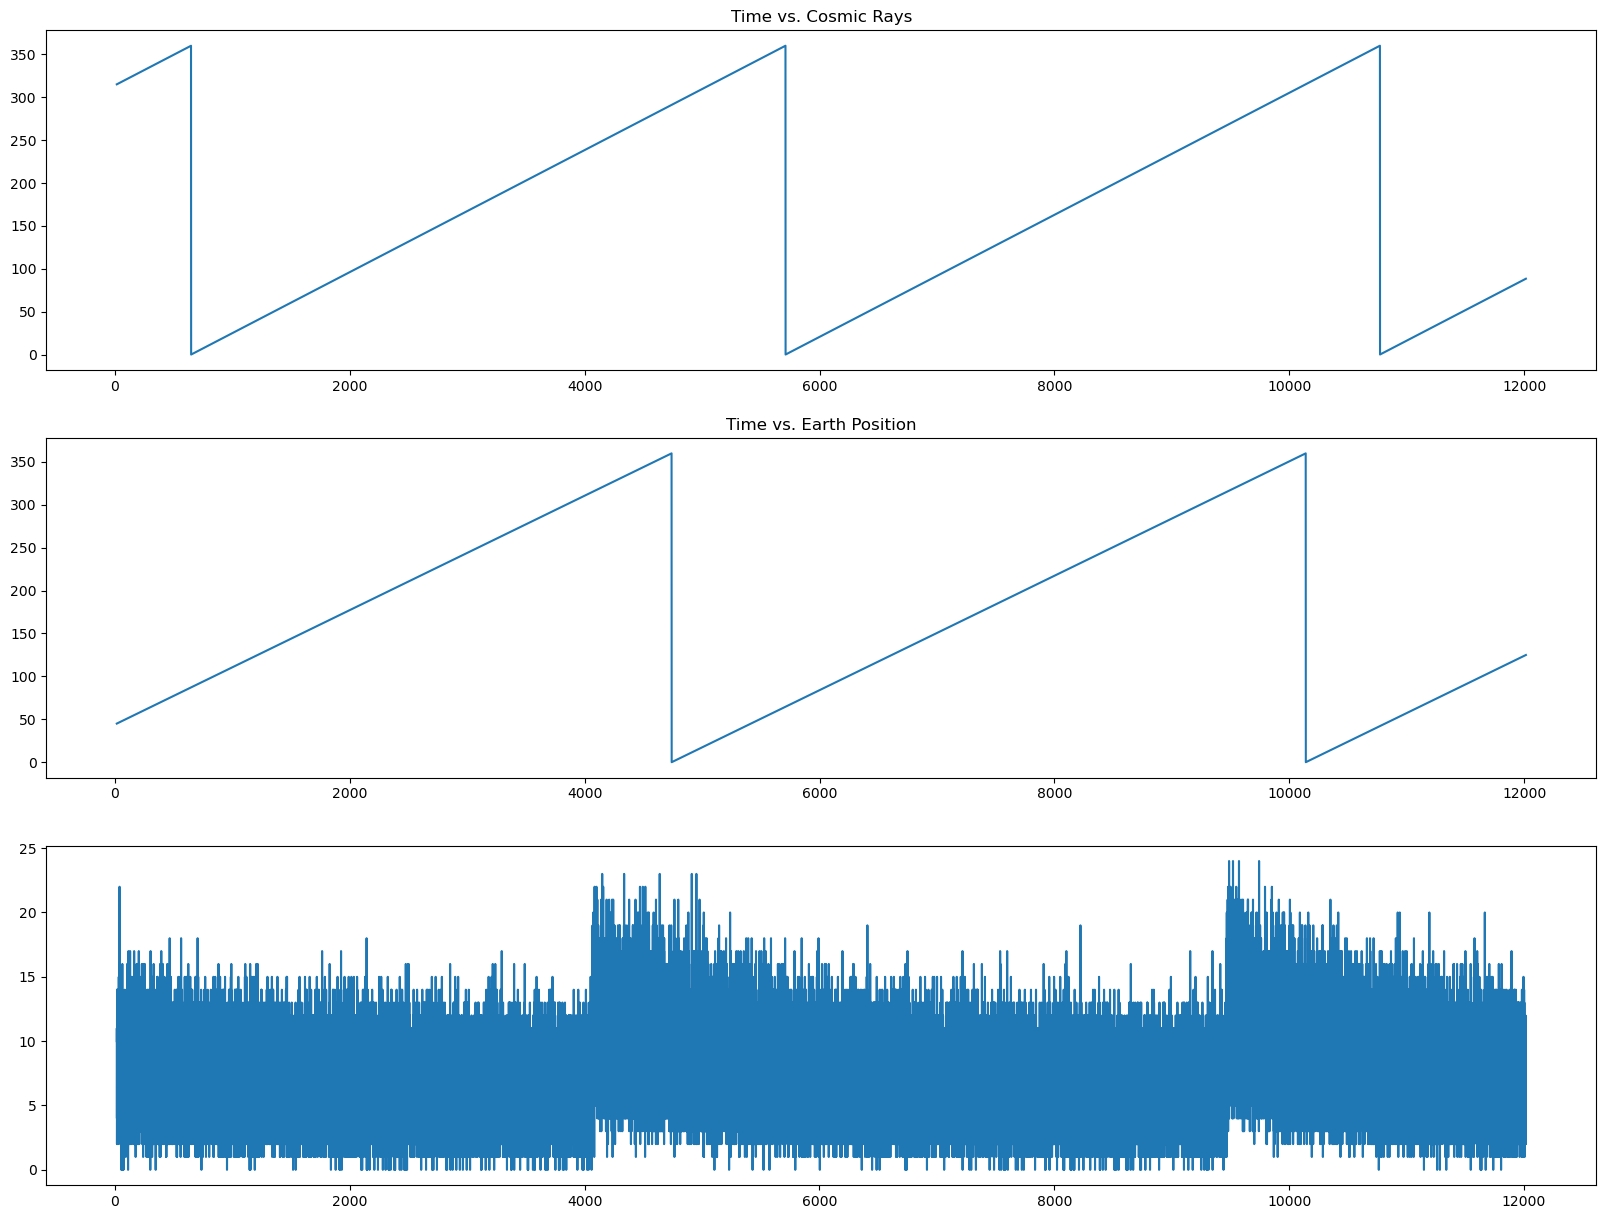

In [3]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15))

graph(time, solar, 0, 12000, 10, 0)
ax[0].set_title("Time vs. Solar Position")

graph(time, earth, 0, 12000, 10, 1)
ax[1].set_title("Time vs. Earth Position")

graph(time, rays, 0, 12000, 1, 2)
ax[0].set_title("Time vs. Cosmic Rays")


Text(0.5, 1.0, 'Time vs. Gamma Rays')

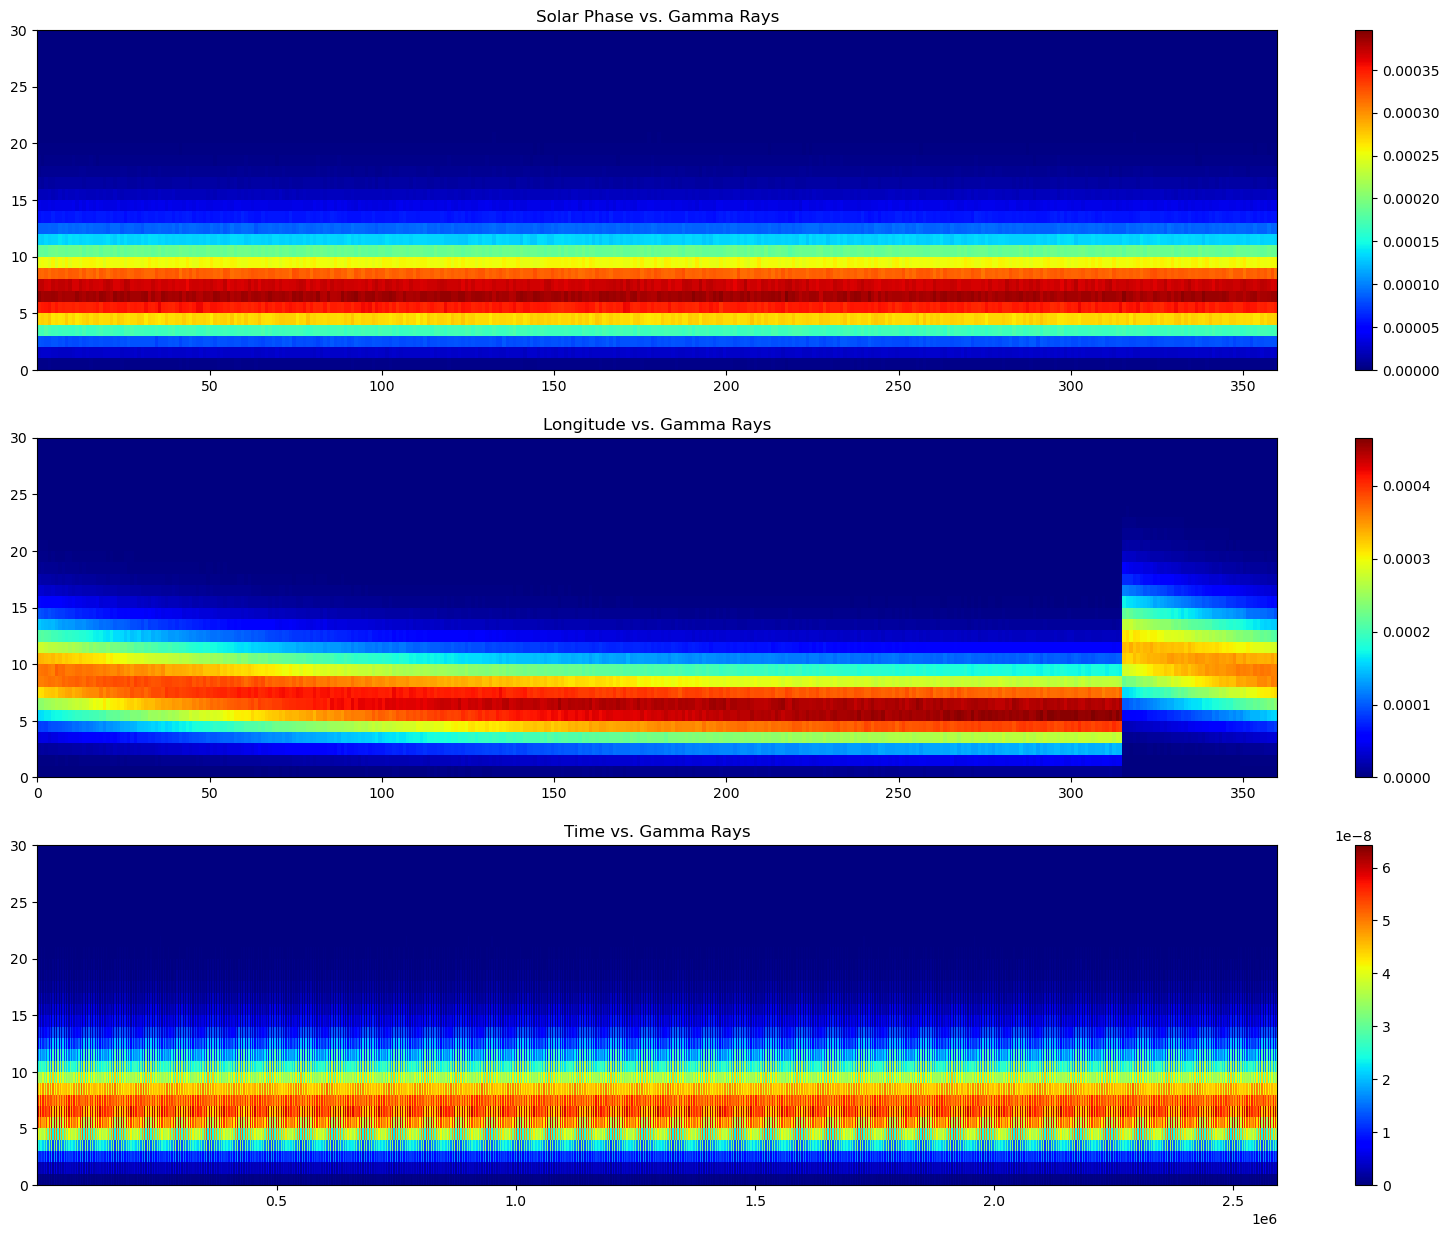

In [4]:
fig, ax = plt.subplots(3, 1, figsize = (20,15))

g = ax[0].hist2d(solar, rays, bins = [360,30], density = True, cmap = plt.cm.jet)
fig.colorbar(g[3], ax = ax[0])
ax[0].set_title("Solar Phase vs. Gamma Rays")

h = ax[1].hist2d(earth, rays, bins = [360,30], density = True, cmap = plt.cm.jet)
fig.colorbar(h[3], ax = ax[1])
ax[1].set_title("Longitude vs. Gamma Rays")

d = ax[2].hist2d(time, rays, bins = [1000,30], density = True, cmap = plt.cm.jet)
fig.colorbar(d[3], ax = ax[2])
ax[2].set_title("Time vs. Gamma Rays")

For background pdf we want f(d), where f gives the ray count as a function of degrees longitude. We know gamma rays normally follow a Poisson distribution, so we need a Poisson for each degree, which boils down to finding the mean gamma rays at each degree (or the mean as a function of degree). This is done from the 2D histogram for longitude. From here we can find d(t), where d gives the longitude at each time, and plug in for f(d(t)) to get f(t).

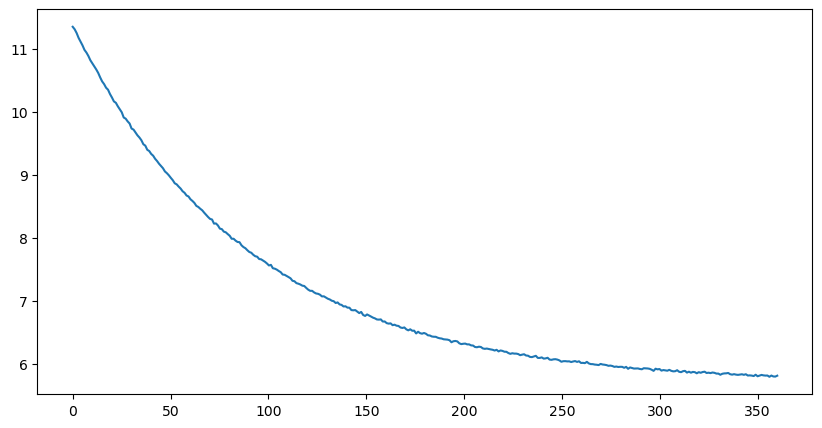

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))

# maxes = []
# for i in range(len(h[1]) - 1):
#     prob_index = np.argmax(h[0][i])
#     maxes.append(prob_index)
    
g = h

means = []
for i in range(len(g[1]) - 1):
    g[0][i] = g[0][i] / np.sum(g[0][i])
    av = 0
    for n in range(len(g[0][i]) - 1):
        av = av + (g[0][i][n] * n)
    means.append(av)

index = 0
for i in range(len(means) - 1):
    if(means[i] >= max(means)):
        index = i
        break

shifted_means = means[0:index]
for i in range(len(means) - index):
    shifted_means.insert(0, means[len(means) - (i + 1)])


ax.plot(np.linspace(0, 360, 360), shifted_means)

[ 8.27148622e+00 -1.10982472e-02  3.41394787e+01  5.69829256e+00]


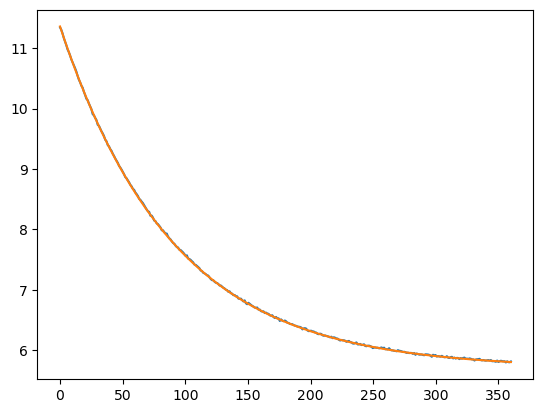

In [143]:
def fit(x, a, b, c, d):
    return a*np.exp(b*(x+c)) + d

guess_a = 5
guess_b = -0.01
guess_c = 15
guess_d = 6

init_guesses = [guess_a, guess_b, guess_c, guess_d]

fitpars, error = curve_fit(fit, np.arange(0, 360, 1), shifted_means, init_guesses)
print(fitpars)

fig, ax = plt.subplots(1, 1)

f_x = fit(x, *fitpars)

def f_mean(x):
    return fitpars[0]*np.exp(fitpars[1]*(x+fitpars[2]))+fitpars[3]
    

x = np.linspace(0, 360, 360)
ax.plot(x, shifted_means)
ax.plot(x, f_mean(x))

Average number of gamma-rays: $f(d) = 6.032e^{-0.01*(x + 5.70)} + 5.70$ for degree (d)

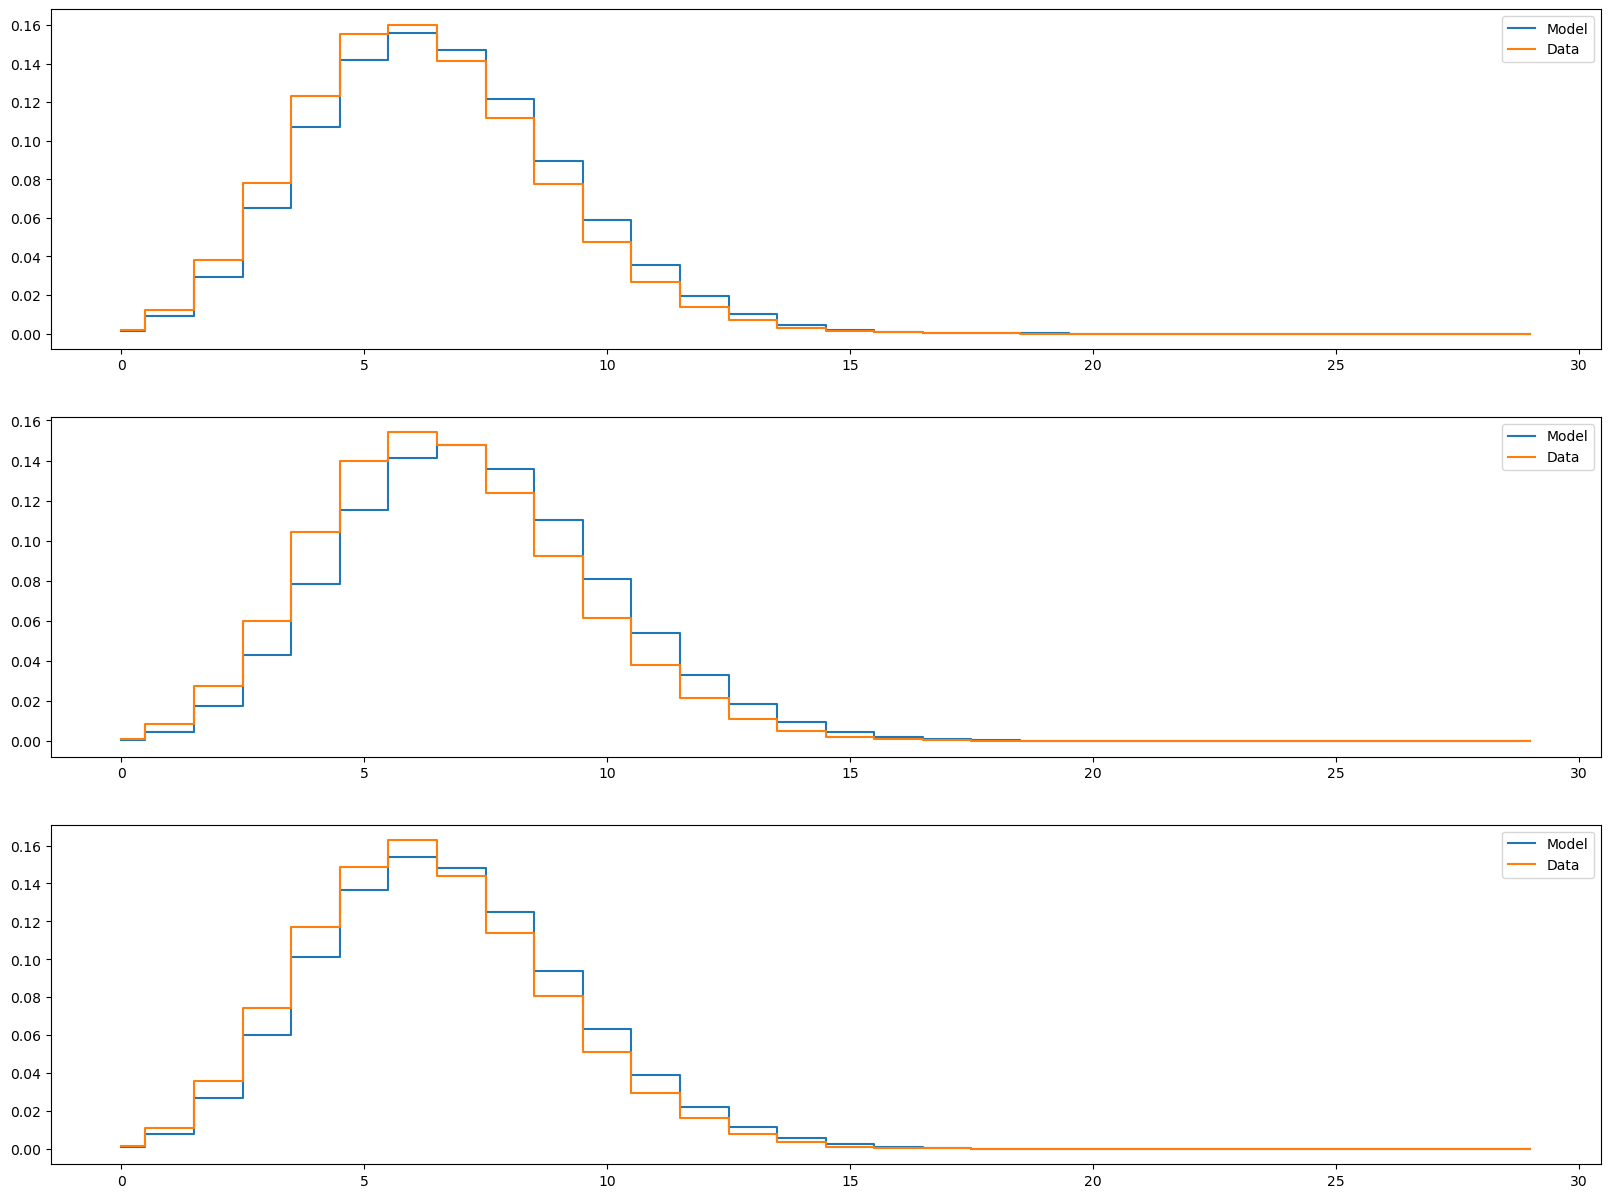

In [154]:
# Input a time (in seconds to the tenths place) to get the background model
# Starts at 0, not the actual GPS time


def time_to_deg(time):
    return int(earth[int(time * 10)])

def bkgd_model(time):
    return f_mean(earth[int(time * 10)])
    
mu = bkgd_model(4000.1)

fig, ax = plt.subplots(3, 1, figsize = (20,15))
x = np.arange(0, 30, 1)

ax[0].step(x, stats.poisson.pmf(x, bkgd_model(1800), loc = 0), where = 'mid')
ax[0].step(x, h[0][time_to_deg(1800)], where = 'mid')
ax[0].legend(["Model", "Data"])

ax[1].step(x, stats.poisson.pmf(x, bkgd_model(1000000), loc = 0), where = 'mid')
ax[1].step(x, h[0][time_to_deg(1000000)], where = 'mid')
ax[1].legend(["Model", "Data"])

ax[2].step(x, stats.poisson.pmf(x, bkgd_model(250000), loc = 0), where = 'mid')
ax[2].step(x, h[0][time_to_deg(250000)], where = 'mid')
ax[2].legend(["Model", "Data"])

# Problem 2

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.79900331, -1.782999  , -1.76699469, -1.75099039, -1.73498608,
        -1.71898177, -1.70297746, -1.68697315, -1.67096884, -1.65496454,
        -1.63896023, -1.62295592, -1.60695161, -1.5909473 , -1.57494299,
        -1.55893868, -1.54293438, -1.52693007, -1.51092576, -1.49492145,
        -1.47891714, -1.46291283, -1.44690853, -1.43090422, -1.41489991,
        -1.3988956 , -1.38289129, -1.36688698, -1.35088267, -1.33487837,
        -1.31887406, -1.30286975, -1.28686544, -1.27086113, -1.25485682,
        -1.23885252, -1.22284821, -1.2068439 , -1.19083959, -1.17483528,
        -1.15883097, -1.14282666, -1.12682236, -1.11081805, -1.09481374,
        -1.07880943, -1.06280512, -1.04680081, -1.03079651, -1.0147922 ,
        -0.99878789, 

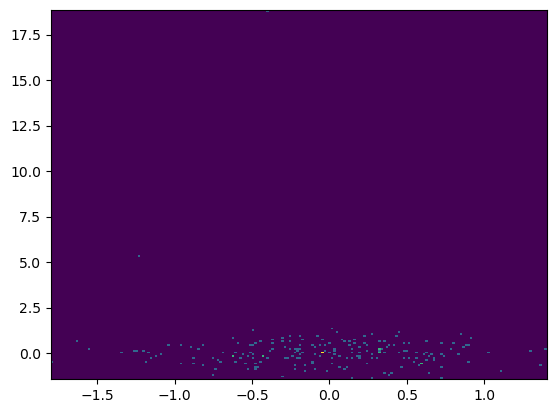

In [183]:
im = h5py.File('images.h5', 'r')
image1 = np.array(im.get('image1'))
imagestack = np.array(im.get('imagestack'))

fig, ax = plt.subplots(1, 1)
ax.hist2d(image1[0],image1[1], bins = 200, density = False)

